In [100]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt

import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
from pitszi import utils

# Simple test case

(8.348772282304804, 367.4872631507755)

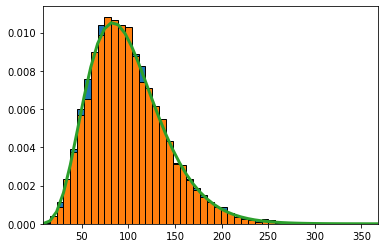

In [3]:
Nmc = 10000
mu = 0
sig = 5
Ncbin = 3 # Number of counts in the bin

# MC realization
pk_stat_i = np.zeros((Ncbin, Nmc))
for ibin in range(Ncbin):
    f1 = np.random.normal(mu,sig, Nmc)
    f2 = np.random.normal(mu,sig, Nmc)
    f3 = np.random.normal(mu,sig, Nmc)
    f4 = np.random.normal(mu,sig, Nmc)
    pk_stat_i[ibin,:] = f1**2 + f2**2 + f3**2 + f4**2
    
# Average in the bin
pk_stat = np.mean(pk_stat_i, axis=0)

# MC realization
bins = np.linspace(np.amin(pk_stat)*0.8, np.amax(pk_stat)*1.2, 50)
plt.hist(pk_stat, bins=bins, density=True, ec='k')

# Model prediction Nbin
xsample = np.linspace(np.amin(pk_stat)*0.8/sig**2*(Ncbin), 
                      np.amax(pk_stat)*1.2/sig**2*(Ncbin), 50)
pdf = scipy.stats.chi2.pdf(xsample, df=4*Ncbin)
dist = scipy.stats.chi2.rvs(df=4*Ncbin, size=Nmc)*sig**2/Ncbin
plt.hist(dist, bins=bins, density=True, ec='k')
plt.plot(xsample*sig**2/(Ncbin), pdf/sig**2*Ncbin, lw=3)
plt.xlim(np.amin(bins),np.amax(bins))

# Bining in k with FFT

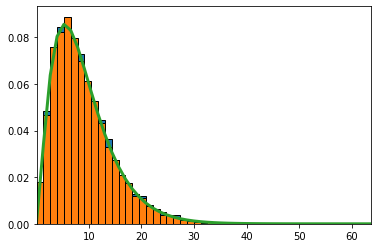

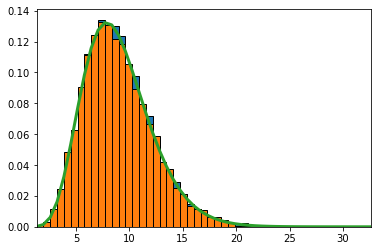

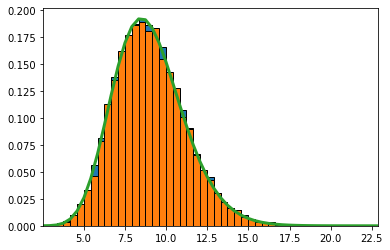

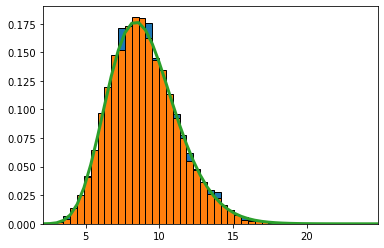

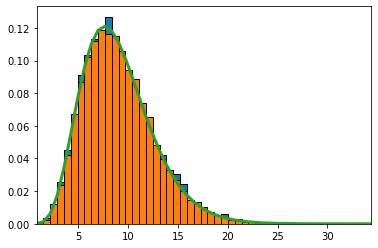

In [46]:
Nmc = 10000
Naxis = 10
reso = 1
mu = 0
sig = 3
Nbin = 5

# Fourier modes
kx = np.fft.fftfreq(Naxis, reso)
ky = np.fft.fftfreq(Naxis, reso)
k2d_x, k2d_y = np.meshgrid(kx, ky, indexing='ij')
k2d_norm = np.sqrt(k2d_x**2 + k2d_y**2)

# Binning in k
kbins = np.linspace(np.amin(k2d_norm), np.amax(k2d_norm), Nbin+1)
kbin_counts, _, _ = stats.binned_statistic(k2d_norm.flatten(), k2d_norm.flatten(), statistic='count', bins=kbins)

# MC realization
pk_stat_i = np.zeros((Nmc, Nbin))
for iMC in range(Nmc):
    field = np.random.normal(mu, sig, (Naxis,Naxis))
    Pk2d = np.abs(np.fft.fftn(field))**2 * reso**2/Naxis**2
    Pk2d_bin, _, _ = stats.binned_statistic(k2d_norm.flatten(), Pk2d.flatten(), statistic='mean', bins=kbins)
    pk_stat_i[iMC, :] = Pk2d_bin
    
# Plot for all k bins
for ib in range(Nbin):
    plt.figure(ib)
    pk_stat = pk_stat_i[:,ib]
    count = kbin_counts[ib]
    bins = np.linspace(np.amin(pk_stat)*0.8, np.amax(pk_stat)*1.2, 50)
    plt.hist(pk_stat, bins=bins, density=True, ec='k')
    
    xsample = np.linspace(np.amin(pk_stat)*0.8, np.amax(pk_stat)*1.2, 50)
    pdf = scipy.stats.chi2.pdf(xsample, df=count, scale=sig**2/count)
    dist = scipy.stats.chi2.rvs(df=count, scale=sig**2/count, size=Nmc)
    plt.hist(dist, bins=bins, density=True, ec='k')
    plt.plot(xsample, pdf, lw=3)
    plt.xlim(np.amin(bins),np.amax(bins))

# With the use of realistic power spectrum

In [129]:
def input_pk(k):
    return amp*(k/k0)**alpha * np.exp(-(1/(k*Linj)**2))

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


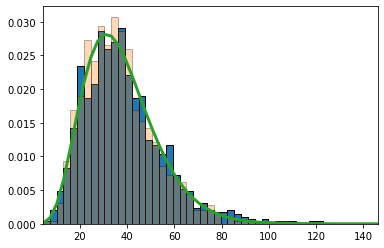

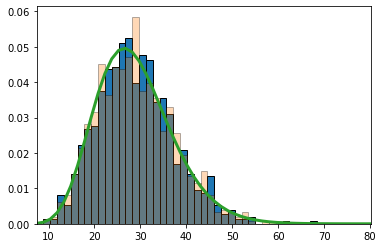

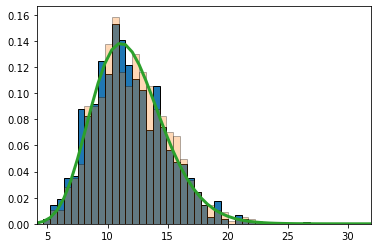

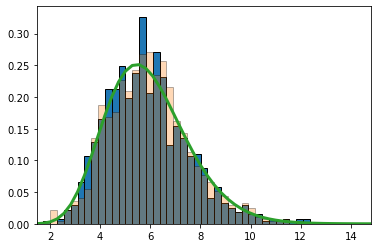

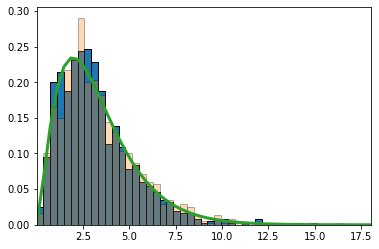

In [156]:
Nmc = 1000
Naxis = 10
reso = 1
Nbin = 5

alpha = -3
k0 = 1
amp = 1.0
Linj = 5

# Fourier modes
kx = np.fft.fftfreq(Naxis, reso)
ky = np.fft.fftfreq(Naxis, reso)
k2d_x, k2d_y = np.meshgrid(kx, ky, indexing='ij')
k2d_norm = np.sqrt(k2d_x**2 + k2d_y**2)

# Binning in k
kbins = np.linspace(np.amin(k2d_norm[k2d_norm>0]), np.amax(k2d_norm), Nbin+1)
kbin_counts, _, _ = stats.binned_statistic(k2d_norm.flatten(), k2d_norm.flatten(), statistic='count', bins=kbins)
kctr = (0.5 * (kbins[1:] + kbins[:-1]))

# MC realization
pk_stat_i = np.zeros((Nmc, Nbin))
for iMC in range(Nmc):
    #build the field
    field = np.random.normal(0, 1, (Naxis,Naxis))
    FFTfield = np.fft.fftn(field)
    amplitude = input_pk(k2d_norm)
    amplitude[k2d_norm == 0] = 0
    amplitude = np.sqrt(amplitude / (reso**2))
    field = np.real(np.fft.ifftn(FFTfield * amplitude))
    
    # extract Pk
    Pk2d = np.abs(np.fft.fftn(field))**2 * reso**2/Naxis**2
    Pk2d_bin, _, _ = stats.binned_statistic(k2d_norm.flatten(), Pk2d.flatten(), statistic='mean', bins=kbins)
    pk_stat_i[iMC, :] = Pk2d_bin
    
# Plot for all k bins
sigma2, _, _ = stats.binned_statistic(k2d_norm.flatten(), input_pk(k2d_norm.flatten()), 
                                      statistic='mean', bins=kbins)
for ib in range(Nbin):
    plt.figure(ib)
    pk_stat = pk_stat_i[:,ib]
    count = kbin_counts[ib]

    sig = sigma2[ib]**0.5
    
    bins = np.linspace(np.amin(pk_stat)*0.8, np.amax(pk_stat)*1.2, 50)
    plt.hist(pk_stat, bins=bins, density=True, ec='k')
    
    xsample = np.linspace(np.amin(pk_stat)*0.8, np.amax(pk_stat)*1.2, 50)
    pdf = scipy.stats.chi2.pdf(xsample, df=count, scale=sig**2/count)
    dist = scipy.stats.chi2.rvs(df=count, scale=sig**2/count, size=Nmc)
    plt.hist(dist, bins=bins, density=True, ec='k', alpha=0.3)
    plt.plot(xsample, pdf, lw=3)
    plt.xlim(np.amin(bins),np.amax(bins))

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


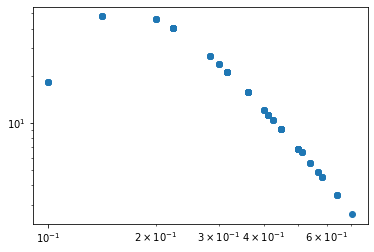

In [157]:
plt.loglog(k2d_norm.flatten(), input_pk(k2d_norm.flatten()), ls='', marker='o')

In [158]:
Nmc=100000
Pkbin_MC = np.zeros((Nmc, Nbin))
for iMC in range(Nmc):
    #build the field
    field = np.random.normal(0, 1, (Naxis,Naxis))
    FFTfield = np.fft.fftn(field)
    amplitude = input_pk(k2d_norm)
    amplitude[k2d_norm == 0] = 0
    amplitude = np.sqrt(amplitude / (reso**2))
    field = np.real(np.fft.ifftn(FFTfield * amplitude))
    
    # extract Pk
    Pk2d = np.abs(np.fft.fftn(field))**2 * reso**2/Naxis**2
    Pk2d_bin, _, _ = stats.binned_statistic(k2d_norm.flatten(), Pk2d.flatten(), statistic='mean', bins=kbins)
    Pkbin_MC[iMC,:] = Pk2d_bin
Pkbin_mean = np.mean(Pkbin_MC, axis=0)
    
cov = np.zeros((Nbin, Nbin))
for iMC in range(Nmc):
    cov += np.matmul((Pkbin_MC[iMC,:] - Pkbin_mean)[:,None], (Pkbin_MC[iMC,:] - Pkbin_mean)[None,:])
cov /= Nmc

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


# Check that the covariance is diagonal for binned Pk without mask

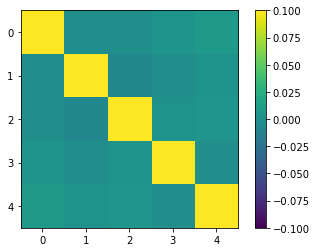

In [159]:
plt.imshow(utils.correlation_from_covariance(cov), vmin=-0.1, vmax=0.1)
plt.colorbar()